In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset

In [2]:
class ConvolutionalVAE1D(nn.Module):
    """
    VAE1D主要函数
    
    """
    
    def __init__(self, input_length=256, latent_dim=32, base_channels=16):
        super().__init__()
        self.latent_dim = latent_dim
        self.base_channels = base_channels
        
        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv1d(1, base_channels, 4, 2, 1), nn.ReLU(),
            nn.Conv1d(base_channels, base_channels*2, 4, 2, 1), nn.ReLU(),
            nn.Conv1d(base_channels*2, base_channels*4, 4, 2, 1), nn.ReLU(),
        )

        # 256 → 128 → 64 → 32
        self.reduced_len = input_length // 8
        flat_dim = base_channels * 4 * self.reduced_len

        # 
        self.fc_mu = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)
        self.fc_z = nn.Linear(latent_dim, flat_dim)

        # 解码器
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(base_channels*4, base_channels*2, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose1d(base_channels*2, base_channels, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose1d(base_channels, 1, 4, 2, 1) # 删掉激活函数
        )

    # 重参数化
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

#-----------------新加的-----------------------
    def select_latent_dims(self, z, selected_dims):
        """
        选择特定的潜变量维度
        
        参数:
        - z: 完整的潜变量 [batch_size, latent_dim]
        - selected_dims: 要选择的维度索引列表
        """
        mask = torch.zeros_like(z)
        mask[:, selected_dims] = 1
        return z * mask
    
    def decode_from_selected_dims(self, z_selected):
        """
        从选择的潜变量维度进行解码
        """
        batch_size = z_selected.size(0)
        x = self.fc_z(z_selected)
        reduced_len = x.numel() // (batch_size * self.base_channels * 4)
        x = x.view(batch_size, self.base_channels * 4, reduced_len)
        return self.decoder(x)

    def forward(self, x, selected_dims=None):
        x = self.encoder(x)
        batch_size, _, _ = x.shape
        x = x.view(x.size(0), -1)
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        
        # 使用选择的维度
        if selected_dims is not None:
            z = self.select_latent_dims(z, selected_dims)
        
        x_recon = self.decode_from_selected_dims(z)
        return x_recon, mu, logvar, z

    
    
def analyze_latent_importance(model, dataloader, device, num_batches=10):
    """
    分析每个潜变量维度的重要性
    
    参数:
    - model: 训练好的VAE模型
    - dataloader: 数据加载器
    - device: 设备 (CPU/GPU)
    - num_batches: 用于分析的批次数量
    """
    model.eval()
    importance_scores = torch.zeros(model.latent_dim).to(device)
    batch_count = 0
    
    print("开始分析潜变量维度重要性...")
    
    with torch.no_grad():
        for batch_idx, (x_batch, _, _) in enumerate(dataloader):
            if batch_idx >= num_batches:  # 只使用前几个批次以节省时间
                break
                
            x_batch = x_batch.to(device)  # 正常前向传播一次（得到完整重建，不用于评分）
            recon_full, _, _, z_full = model(x_batch)
            
            # 计算每个维度单独的重建质量
            for dim in tqdm(range(model.latent_dim), desc=f"分析批次 {batch_idx+1}/{num_batches}"):
                # 只使用当前维度
                recon_dim = model(x_batch, selected_dims=[dim])[0]
                # 计算重建损失作为重要性指标（损失越小，维度越重要）
                loss = F.mse_loss(recon_dim, x_batch, reduction='mean')
                importance_scores[dim] += loss.item()
            
            batch_count += 1
    
    # 平均损失
    importance_scores /= batch_count
    
    # 按重要性排序（损失越小越重要）
    sorted_indices = torch.argsort(importance_scores)
    
    print("\n潜变量维度重要性分析完成!")
    print(f"最重要维度: {sorted_indices[:5].cpu().numpy()}")
    print(f"最不重要维度: {sorted_indices[-5:].cpu().numpy()}")
    
    return sorted_indices.cpu().numpy(), importance_scores.cpu().numpy()

def select_and_visualize_dims(importance_scores, num_selected=20):
    """
    选择最重要的维度并可视化
    
    参数:
    - importance_scores: 每个维度的重要性分数
    - num_selected: 要选择的维度数量
    """
    # 按重要性排序（损失越小越重要）
    sorted_indices = np.argsort(importance_scores)
    
    # 选择最重要的维度
    selected_dims = sorted_indices[:num_selected].tolist()
    
    print(f"选择了最重要的 {num_selected} 个维度:")
    print(f"维度索引: {selected_dims}")
    
    # 可视化重要性
    plt.figure(figsize=(12, 6))
    
    # 绘制所有维度的重要性
    plt.subplot(1, 2, 1)
    plt.bar(range(len(importance_scores)), importance_scores)
    plt.xlabel('latent_dim')
    plt.ylabel('reconstruct loss')
    plt.title('Importance of latent_dim')
    
    # 标记选择的维度
    plt.scatter(selected_dims, importance_scores[selected_dims], 
               color='red', s=50, zorder=5, label='selected dim')
    plt.legend()
    
    # 绘制排序后的重要性
    plt.subplot(1, 2, 2)
    sorted_scores = np.sort(importance_scores)
    plt.plot(range(len(sorted_scores)), sorted_scores, 'b-', linewidth=2)
    plt.xlabel('order of dim')
    plt.ylabel('reconstruct loss')
    plt.title('order of importance of latent_dim')
    
    # 标记选择的维度数量
    plt.axvline(x=num_selected, color='red', linestyle='--', 
                label=f'select{num_selected}dim')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return selected_dims

def compare_reconstructions(model, dataloader, device, selected_dims, num_samples=3):
    """
    比较完整重建和部分重建的效果
    
    参数:
    - model: 训练好的VAE模型
    - dataloader: 数据加载器
    - device: 设备
    - selected_dims: 选择的维度索引
    - num_samples: 要显示的样本数量
    """
    model.eval()
    
    with torch.no_grad():
        for batch_idx, (x_batch, names, scales) in enumerate(dataloader):
            if batch_idx >= 1:  # 只使用第一个批次
                break
                
            x_batch = x_batch.to(device)
            scales = scales.to(device)
            
            # 完整重建（使用全部维度）
            recon_full, _, _, _ = model(x_batch)
            
            # 使用选择的维度重建
            recon_selected, _, _, _ = model(x_batch, selected_dims=selected_dims)
            
            # 反归一化
            x_original = x_batch * scales
            recon_full_denorm = recon_full * scales
            recon_selected_denorm = recon_selected * scales
            
            # 计算损失
            loss_full = F.mse_loss(recon_full, x_batch).item()
            loss_selected = F.mse_loss(recon_selected, x_batch).item()
            
            print(f"完整重建损失: {loss_full:.4f}")
            print(f"使用{len(selected_dims)}个维度的重建损失: {loss_selected:.4f}")
            print(f"重建质量保持: {(1 - loss_selected/loss_full)*100:.2f}%")
            
            # 在同一张图中比较原始谱线和重建谱线
            for i in range(min(num_samples, x_batch.size(0))):
                plt.figure(figsize=(12, 6))
                
                # 获取数据
                original_data = x_original[i].squeeze().cpu().numpy()
                full_recon_data = recon_full_denorm[i].squeeze().cpu().numpy()
                selected_recon_data = recon_selected_denorm[i].squeeze().cpu().numpy()
                
                # 绘制在同一张图上
                plt.plot(original_data, 'k-', linewidth=2, label='original data')
                plt.plot(full_recon_data, 'b-', linewidth=1.5, label='full reconstruct (32)', alpha=0.8)
                plt.plot(selected_recon_data, 'r--', linewidth=1.5, label=f'select {len(selected_dims)} dim', alpha=0.8)
                
                plt.title(f'compare_reconstructions - {names[i]}')
                plt.xlabel('fre')
                plt.ylabel('flux')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                # 添加文本说明
                textstr = '\n'.join((
                    f'full reconstructions loss: {loss_full:.4f}',
                    f'select{len(selected_dims)}dim to reconstruct: {loss_selected:.4f}',
                    f'Maintaining the quality of reconstruction: {(1 - loss_selected/loss_full)*100:.2f}%'
                ))
                props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
                plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
                        verticalalignment='top', bbox=props)
                
                plt.tight_layout()
                plt.show()
                
            break


In [25]:
# 加载数据集
%run data.ipynb
old_data=create_data_Results()
dataset=old_data.dataset


65
65
找到 15 个光谱文件
处理文件: spectrum.Lh07.spw0.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw0
  [INFO] 应用速度修正: v = 239.516 km/s
开始提取子光谱
总共有65条光谱
------------------------------
1
2
3
4
5
6
7
8
9
10
11
处理文件: spectrum.Lh07.spw1.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw1
  [INFO] 应用速度修正: v = 239.516 km/s
开始提取子光谱
总共有65条光谱
------------------------------
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
处理文件: spectrum.Lh07.spw2.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw2
  [INFO] 应用速度修正: v = 239.516 km/s
开始提取子光谱
总共有65条光谱
------------------------------
1
2
3
4
5
6
7
8
9
10
11
12
13
处理文件: spectrum.Lh07.spw3.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw3
  [INFO] 应用速度修正: v = 239.516 km/s
开始提取子光谱
总共有65条光谱
------------------------------
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
处理文件: spectrum.Lh07.spw4.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw4
  [INFO] 应用速度修正: v = 239.516 km/s
开始提取子光谱
总共有65条光谱
------------------------------
1
2
3
4
5
6
7
8
9
处理文件: spectrum.Lh09.spw0.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw0
  

In [26]:
# 创建子数据集
#indices = random.sample(range(len(dataset)), 100)
indices = list(range(100))

# 创建子集
subset = Subset(dataset, indices)

In [27]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)

BATCH_SIZE = 8
dataloader_test = DataLoader(
    subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)

In [19]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def vae_loss(recon_x, x, mu, logvar, beta=1e-3):
    mse = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (mse + beta * kld) / x.size(0)

# 初始化模型
model = ConvolutionalVAE1D(input_length=256, latent_dim=32).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 训练
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for x_batch, name,scales in pbar:  # 注意 dataset 返回 (tensor, name,scales)
        x_batch = x_batch.to(DEVICE)
        scales=scales.to(DEVICE)
        
        optimizer.zero_grad()
        
        recon, mu, logvar, _ = model(x_batch)
        
        loss = vae_loss(recon, x_batch, mu, logvar)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    print(f"Epoch {epoch+1}: avg loss = {total_loss/len(dataloader):.4f}")

Epoch 1/50: 100%|█████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 62.94it/s, loss=6.8864]


Epoch 1: avg loss = 43.9011


Epoch 2/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 60.82it/s, loss=17.0503]


Epoch 2: avg loss = 20.8244


Epoch 3/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 62.46it/s, loss=12.4313]


Epoch 3: avg loss = 16.6340


Epoch 4/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 62.34it/s, loss=33.3198]


Epoch 4: avg loss = 15.0055


Epoch 5/50: 100%|█████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 59.26it/s, loss=1.2728]


Epoch 5: avg loss = 11.9272


Epoch 6/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 62.06it/s, loss=22.6672]


Epoch 6: avg loss = 11.1717


Epoch 7/50: 100%|█████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 56.57it/s, loss=1.8083]


Epoch 7: avg loss = 9.3239


Epoch 8/50: 100%|█████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 56.51it/s, loss=1.0268]


Epoch 8: avg loss = 8.2918


Epoch 9/50: 100%|█████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 49.93it/s, loss=2.7273]


Epoch 9: avg loss = 7.5283


Epoch 10/50: 100%|███████████████████████████████████████████████████████| 26/26 [00:00<00:00, 52.94it/s, loss=14.3276]


Epoch 10: avg loss = 7.3503


Epoch 11/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 51.28it/s, loss=0.7337]


Epoch 11: avg loss = 6.3391


Epoch 12/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 43.77it/s, loss=0.3816]


Epoch 12: avg loss = 5.6975


Epoch 13/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 42.73it/s, loss=0.7328]


Epoch 13: avg loss = 5.1854


Epoch 14/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 42.82it/s, loss=1.2602]


Epoch 14: avg loss = 4.7420


Epoch 15/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 49.86it/s, loss=9.9692]


Epoch 15: avg loss = 4.6479


Epoch 16/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 50.75it/s, loss=2.2792]


Epoch 16: avg loss = 4.1595


Epoch 17/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 50.98it/s, loss=1.2325]


Epoch 17: avg loss = 3.6901


Epoch 18/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 47.35it/s, loss=7.6299]


Epoch 18: avg loss = 3.7042


Epoch 19/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 43.00it/s, loss=5.7566]


Epoch 19: avg loss = 3.4216


Epoch 20/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 45.99it/s, loss=6.7814]


Epoch 20: avg loss = 3.1499


Epoch 21/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 47.06it/s, loss=6.7688]


Epoch 21: avg loss = 2.9204


Epoch 22/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 50.76it/s, loss=0.8393]


Epoch 22: avg loss = 2.9434


Epoch 23/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 49.36it/s, loss=0.4088]


Epoch 23: avg loss = 2.4579


Epoch 24/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 51.77it/s, loss=2.9883]


Epoch 24: avg loss = 2.2301


Epoch 25/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 49.08it/s, loss=1.5377]


Epoch 25: avg loss = 1.9386


Epoch 26/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 51.97it/s, loss=2.6531]


Epoch 26: avg loss = 1.8074


Epoch 27/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 51.84it/s, loss=2.7552]


Epoch 27: avg loss = 1.8811


Epoch 28/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 48.85it/s, loss=3.5404]


Epoch 28: avg loss = 1.9306


Epoch 29/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 51.79it/s, loss=2.1588]


Epoch 29: avg loss = 1.7709


Epoch 30/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 50.20it/s, loss=0.3158]


Epoch 30: avg loss = 1.5565


Epoch 31/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 51.02it/s, loss=1.9224]


Epoch 31: avg loss = 1.4197


Epoch 32/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 49.82it/s, loss=1.0371]


Epoch 32: avg loss = 1.4736


Epoch 33/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 50.73it/s, loss=1.6485]


Epoch 33: avg loss = 1.3518


Epoch 34/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 57.43it/s, loss=1.4616]


Epoch 34: avg loss = 1.3129


Epoch 35/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 54.43it/s, loss=1.9403]


Epoch 35: avg loss = 1.4097


Epoch 36/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 54.88it/s, loss=0.4808]


Epoch 36: avg loss = 1.1392


Epoch 37/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 56.92it/s, loss=1.1921]


Epoch 37: avg loss = 1.0550


Epoch 38/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 54.42it/s, loss=0.9093]


Epoch 38: avg loss = 1.0369


Epoch 39/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 54.72it/s, loss=1.2991]


Epoch 39: avg loss = 1.0229


Epoch 40/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 58.48it/s, loss=1.6316]


Epoch 40: avg loss = 1.1648


Epoch 41/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 61.57it/s, loss=0.3213]


Epoch 41: avg loss = 0.9792


Epoch 42/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 58.28it/s, loss=1.4480]


Epoch 42: avg loss = 0.9463


Epoch 43/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 57.41it/s, loss=0.7476]


Epoch 43: avg loss = 0.9174


Epoch 44/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 61.82it/s, loss=0.8195]


Epoch 44: avg loss = 0.8480


Epoch 45/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 59.01it/s, loss=1.0814]


Epoch 45: avg loss = 0.8181


Epoch 46/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 60.27it/s, loss=0.3661]


Epoch 46: avg loss = 0.7927


Epoch 47/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 63.16it/s, loss=0.9598]


Epoch 47: avg loss = 0.8337


Epoch 48/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 59.81it/s, loss=0.8458]


Epoch 48: avg loss = 0.8486


Epoch 49/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 58.73it/s, loss=1.4609]


Epoch 49: avg loss = 0.9494


Epoch 50/50: 100%|████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 60.73it/s, loss=1.1834]

Epoch 50: avg loss = 1.0416


=== Step 1: Analyzing latent dimension importance ===
开始分析潜变量维度重要性...


分析批次 5/5: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 188.23it/s]



潜变量维度重要性分析完成!
最重要维度: [ 0 26 20 14  3]
最不重要维度: [ 9  4 22 30 11]

=== Step 2: Selecting the most important dimensions ===
选择了最重要的 20 个维度:
维度索引: [0, 26, 20, 14, 3, 2, 19, 5, 18, 24, 13, 25, 6, 12, 10, 7, 27, 31, 23, 28]


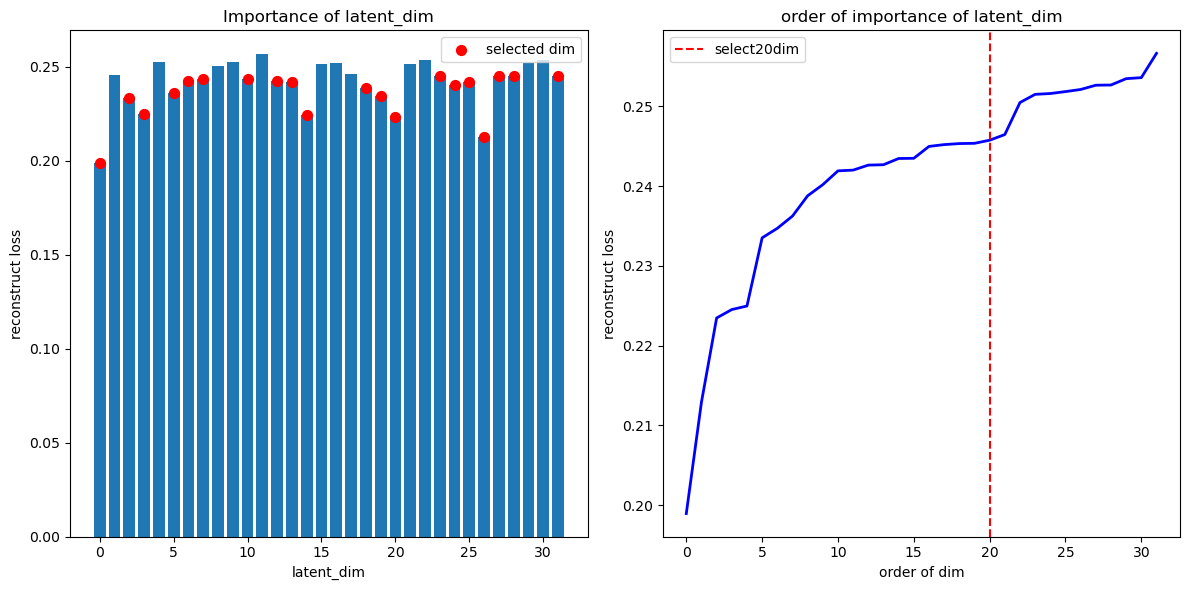


=== Step 3: Comparing reconstruction performance ===
完整重建损失: 0.0035
使用20个维度的重建损失: 0.0386
重建质量保持: -999.88%


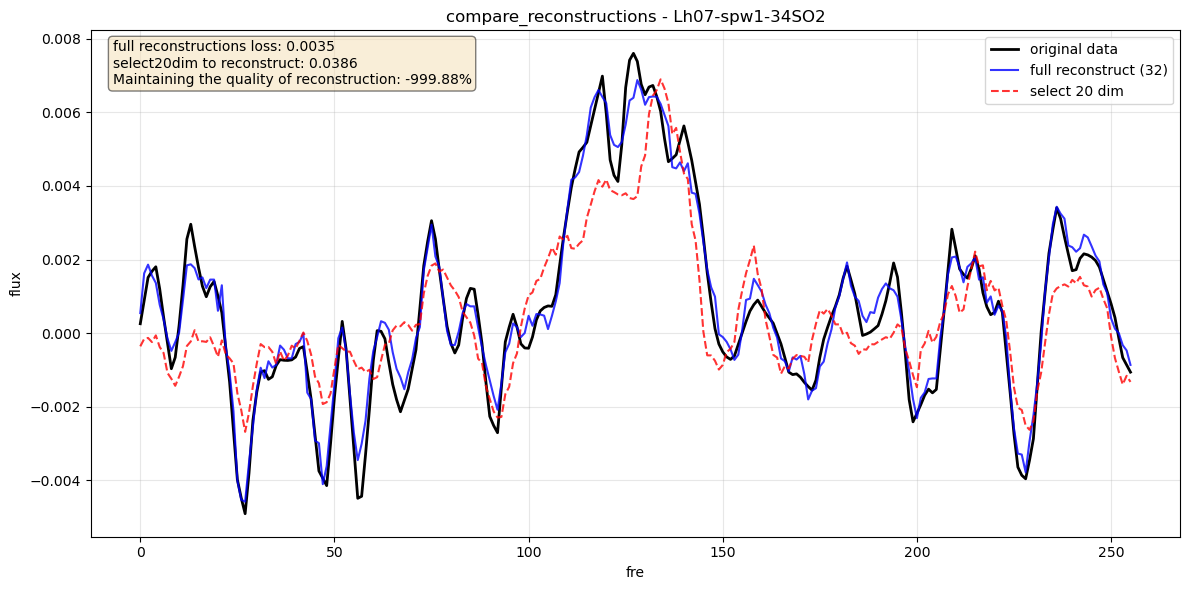

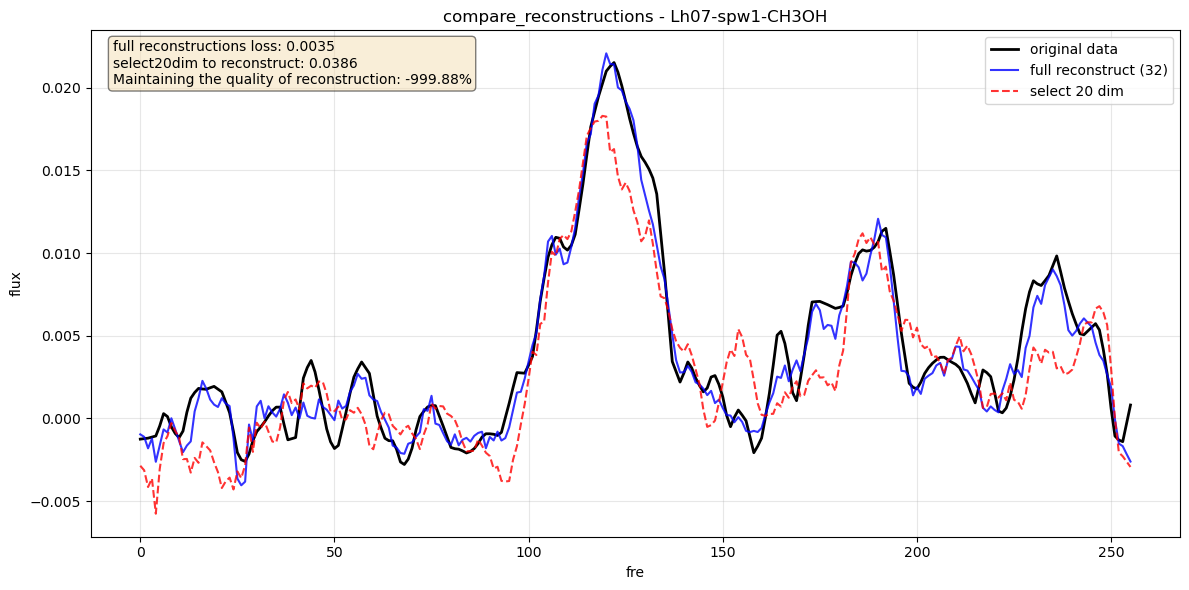

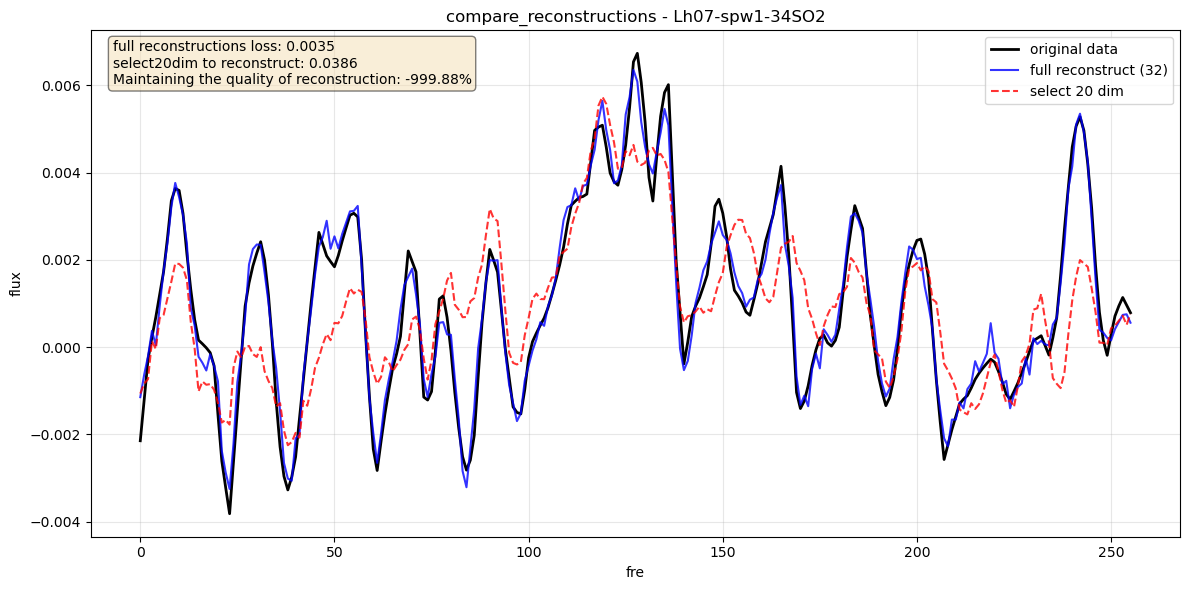

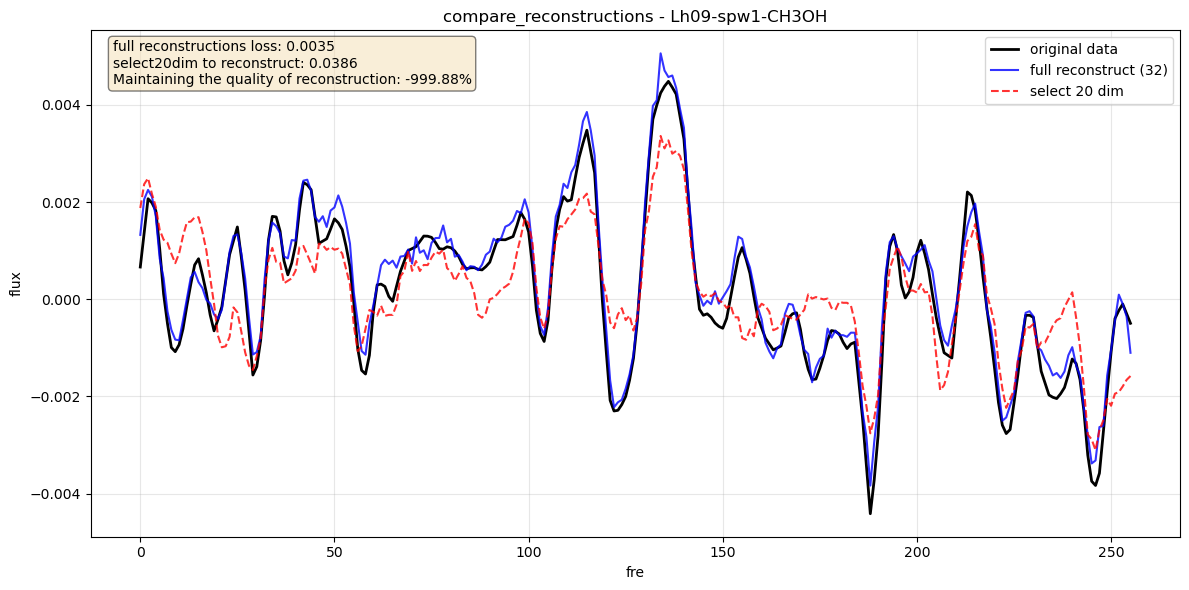

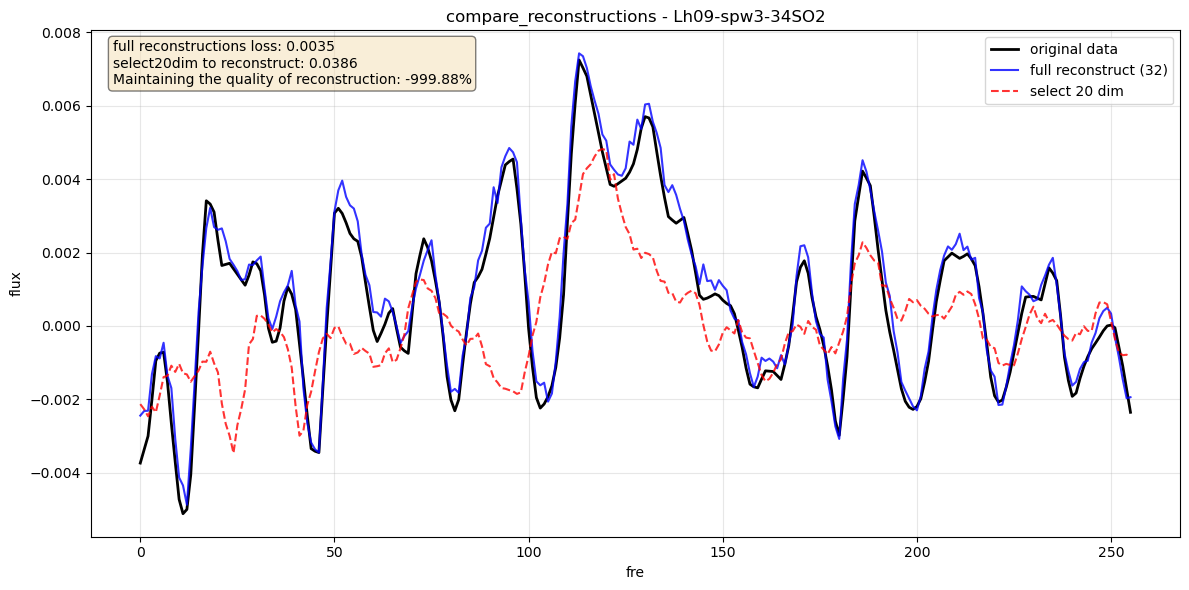

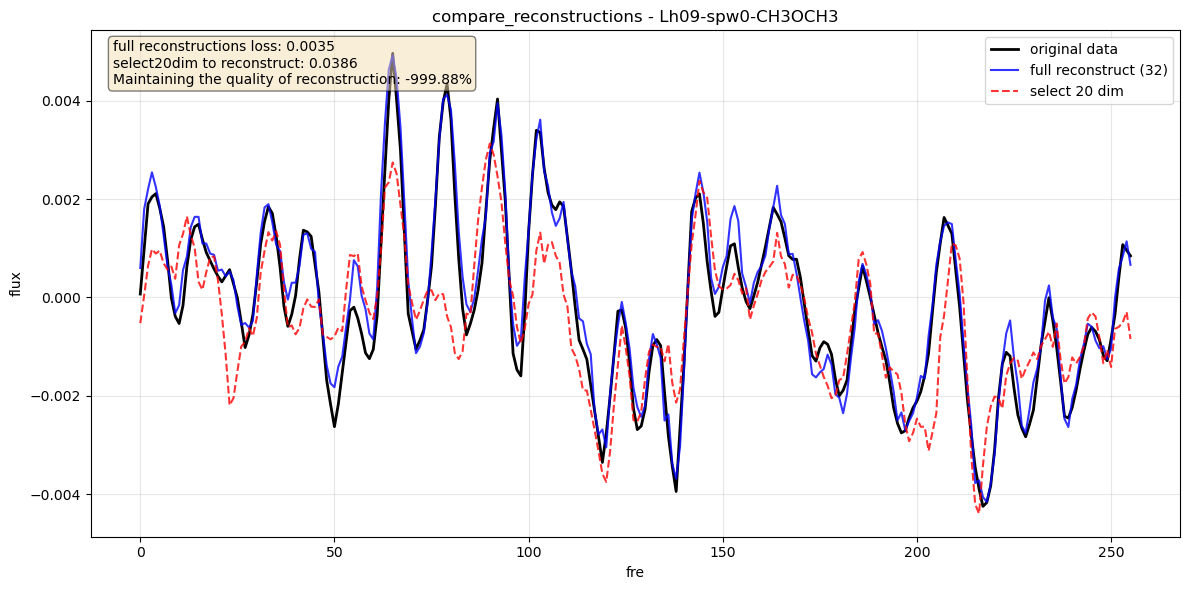

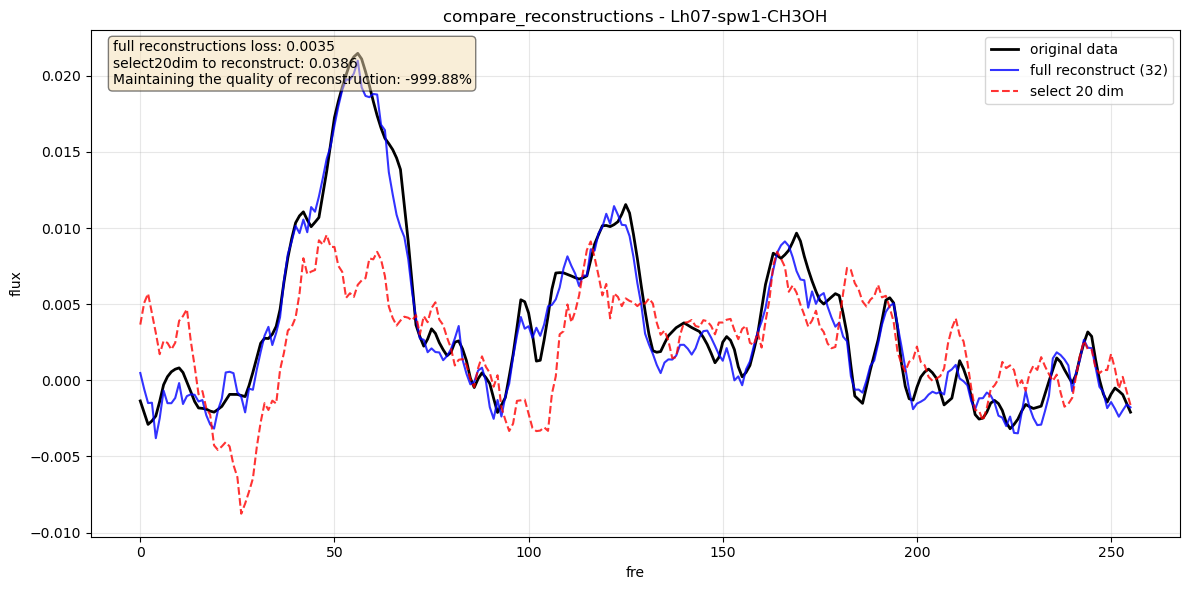

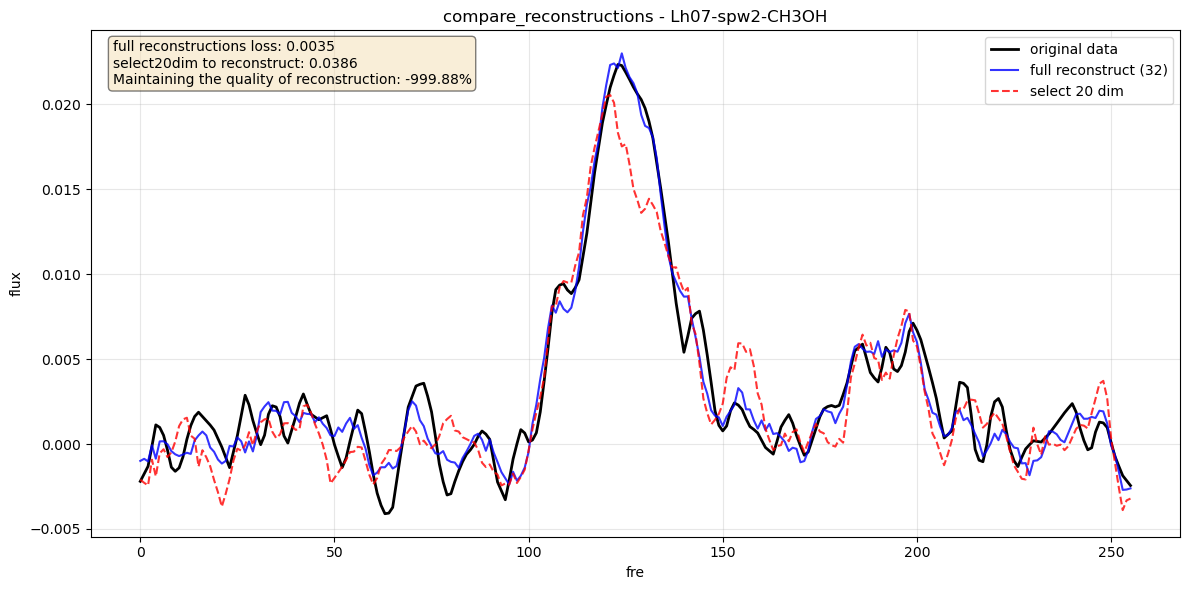


=== Complete! ===


In [30]:
def main():
    """
    完整的使用示例：分析维度重要性并比较重建效果
    """
    # 假设您已经训练好模型并创建了数据加载器
    # model = 训练好的VAE模型
    # dataloader = 数据加载器
    # DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    print("=== Step 1: Analyzing latent dimension importance ===")
    # 分析潜变量维度重要性
    sorted_dims, importance_scores = analyze_latent_importance(
        model, dataloader, DEVICE, num_batches=5
    )
    
    print("\n=== Step 2: Selecting the most important dimensions ===")
    # 选择最重要的20个维度
    num_selected = 20
    selected_dims = select_and_visualize_dims(importance_scores, num_selected)
    
    print("\n=== Step 3: Comparing reconstruction performance ===")
    # 比较重建效果
    compare_reconstructions(model, dataloader, DEVICE, selected_dims, num_samples=15)
    
    print("\n=== Complete! ===")

# 运行示例
if __name__ == "__main__":
    main()

=== Step 1: Analyzing latent dimension importance ===
开始分析潜变量维度重要性...


分析批次 5/5: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 169.08it/s]



潜变量维度重要性分析完成!
最重要维度: [ 0 26 14 20  3]
最不重要维度: [31 15  9 30  8]

=== Step 2: Selecting the most important dimensions ===
选择了最重要的 20 个维度:
维度索引: [0, 26, 14, 20, 3, 2, 5, 19, 25, 1, 18, 27, 13, 10, 28, 6, 7, 24, 12, 17]


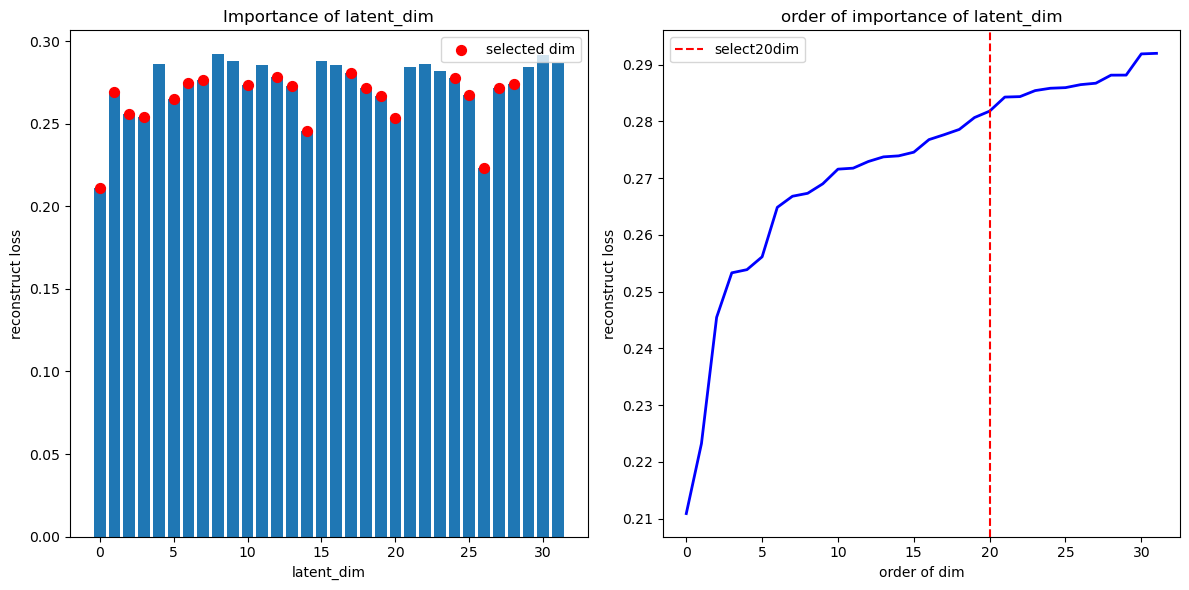


=== Step 3: Comparing reconstruction performance ===
完整重建损失: 0.0026
使用20个维度的重建损失: 0.0226
重建质量保持: -754.30%


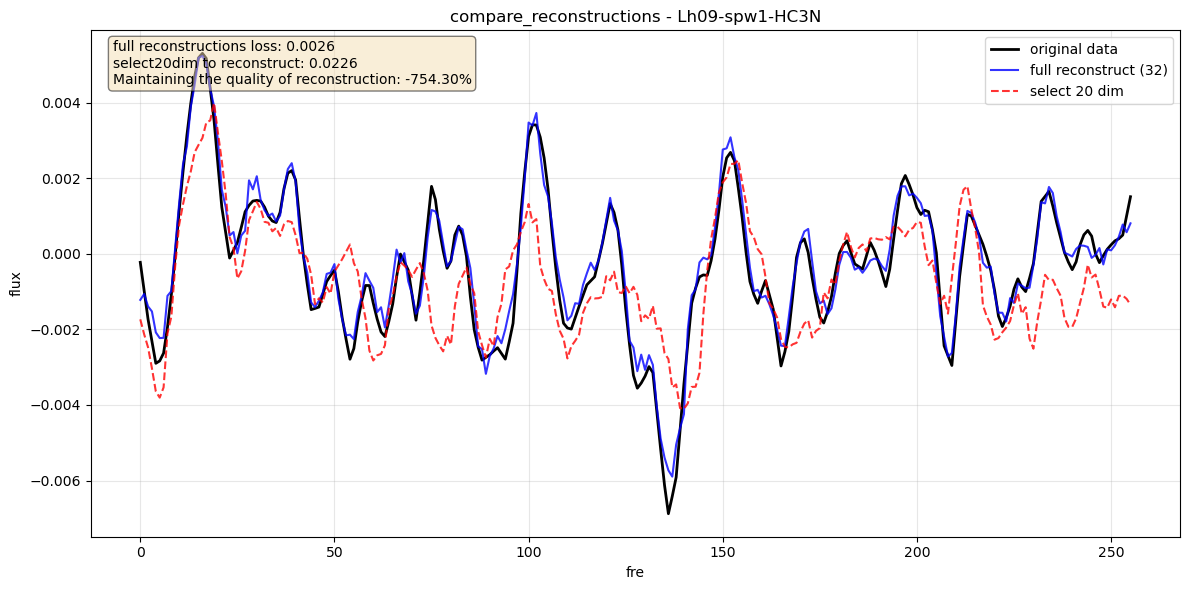

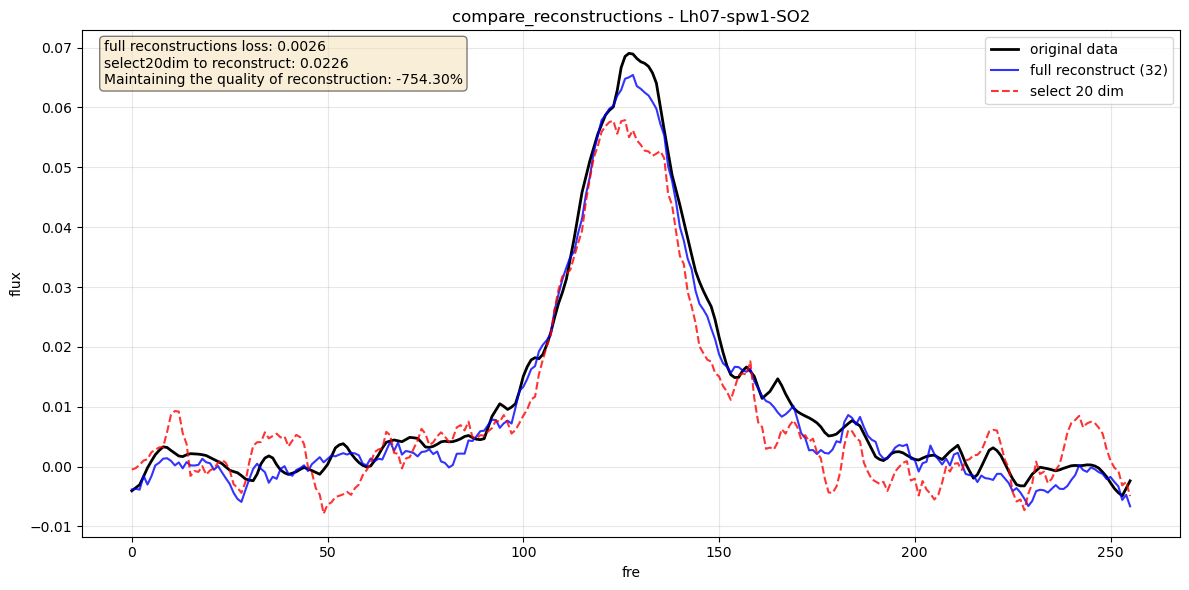

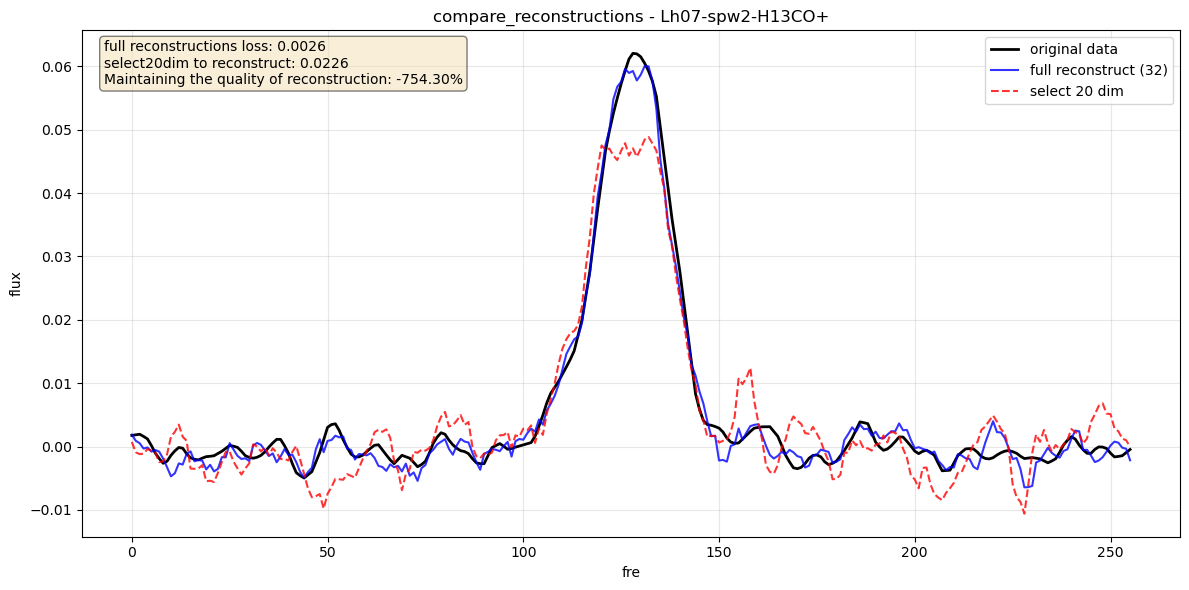

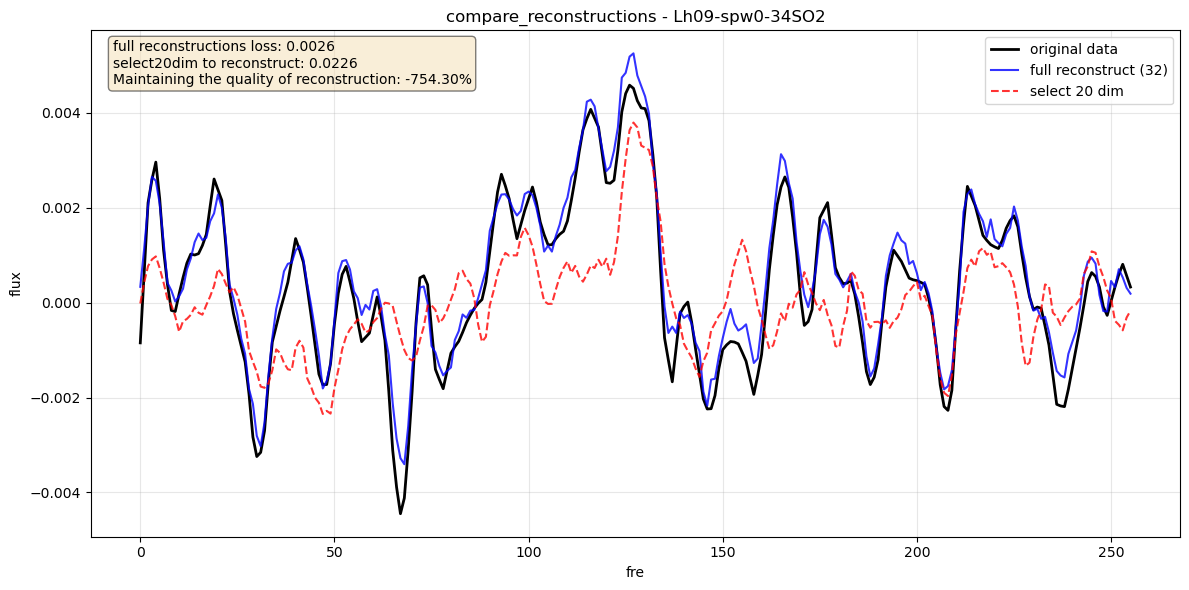

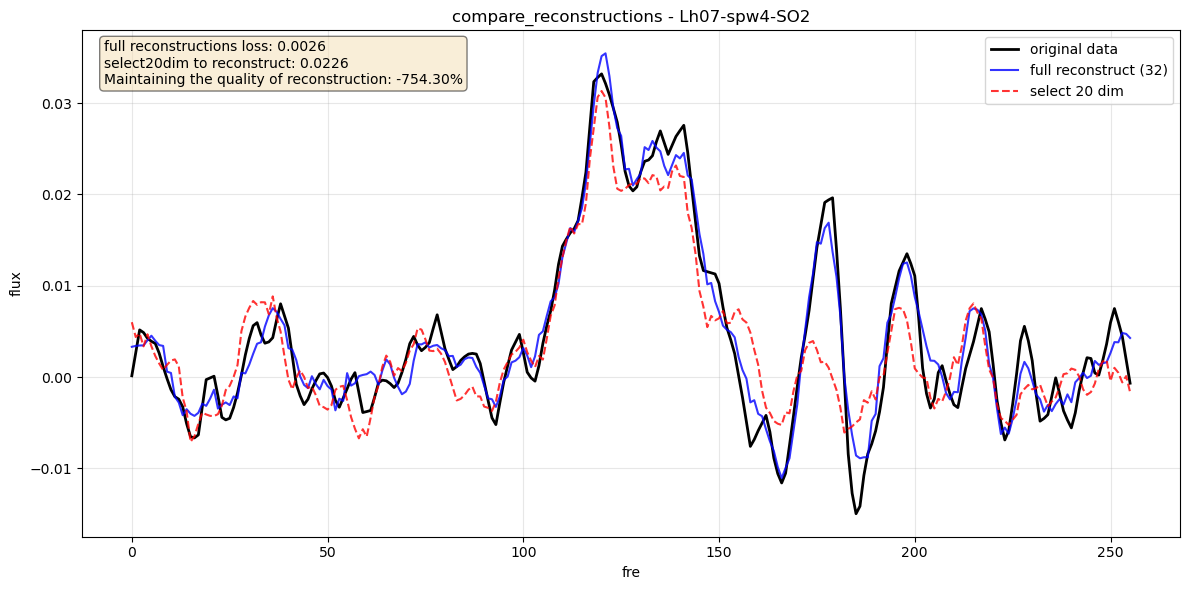

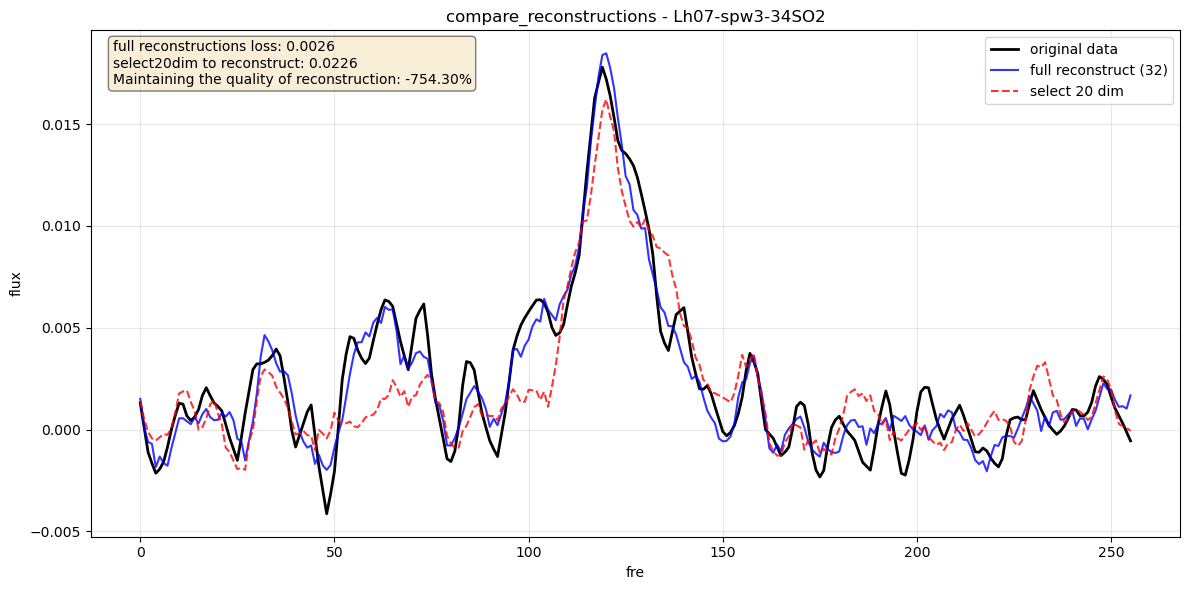

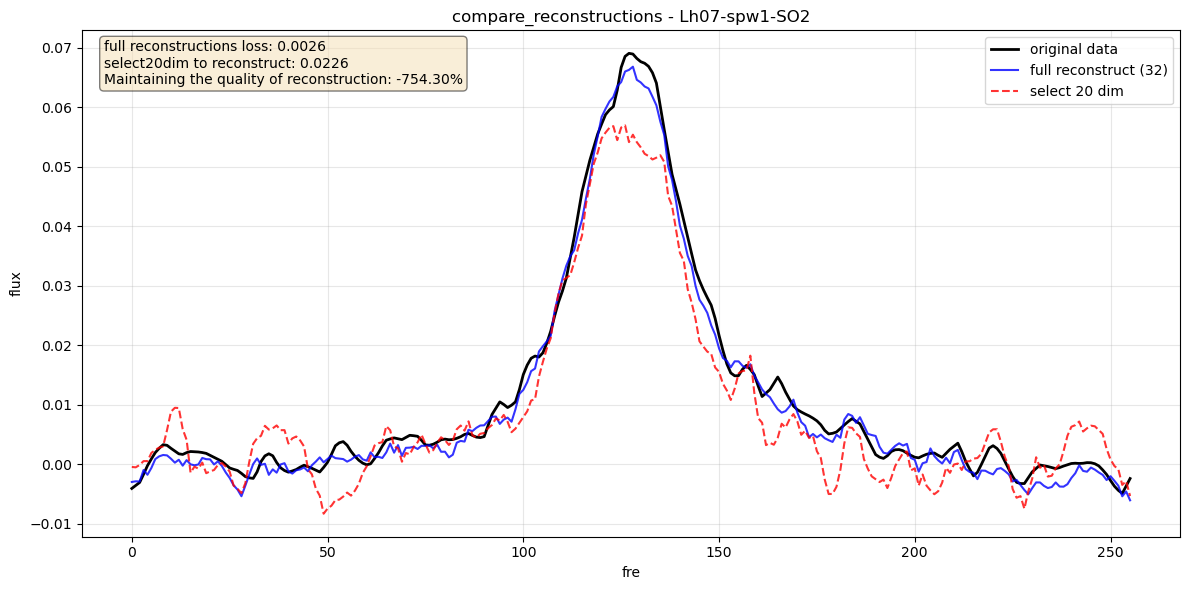

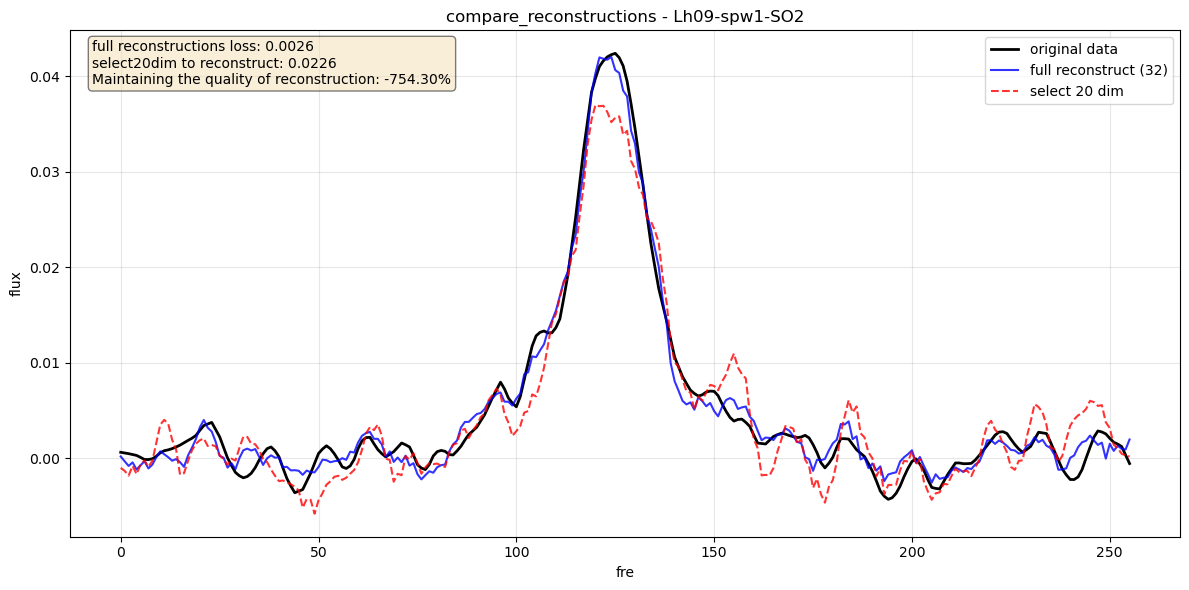


=== Complete! ===


In [28]:
def main():
    """
    完整的使用示例：分析维度重要性并比较重建效果
    """
    # 假设您已经训练好模型并创建了数据加载器
    # model = 训练好的VAE模型
    # dataloader = 数据加载器
    # DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    print("=== Step 1: Analyzing latent dimension importance ===")
    # 分析潜变量维度重要性
    sorted_dims, importance_scores = analyze_latent_importance(
        model, dataloader, DEVICE, num_batches=5
    )
    
    print("\n=== Step 2: Selecting the most important dimensions ===")
    # 选择最重要的20个维度
    num_selected = 20
    selected_dims = select_and_visualize_dims(importance_scores, num_selected)
    
    print("\n=== Step 3: Comparing reconstruction performance ===")
    # 比较重建效果
    compare_reconstructions(model, dataloader_test, DEVICE, selected_dims, num_samples=15)
    
    print("\n=== Complete! ===")

# 运行示例
if __name__ == "__main__":
    main()

In [31]:
features = []
names_all = []
all_original = []

model.eval()
with torch.no_grad():
    for x_batch, names, scales in dataloader:  # ✅ 现在有 scales
        x_batch = x_batch.to(DEVICE)
        _, _, _, z = model(x_batch)
        features.append(z.cpu())
        names_all.extend(names)
        
        original = x_batch #* scales
        all_original.append(original.cpu())

features = torch.cat(features).numpy()
all_original = torch.cat(all_original, dim=0).numpy().squeeze(1)

print(features)
print(names_all[5][10:])
print(names_all[0])
print(len(all_original))

[[ 2.1996677  -1.4400334   1.2240312  ... -0.5300017   1.2051777
  -1.3184743 ]
 [ 1.572566    0.6004279   0.2786263  ... -0.7213508  -0.9087531
   0.01242505]
 [ 2.5306606  -0.87398374 -1.6087247  ... -0.3857481  -0.23310709
  -0.702552  ]
 ...
 [ 0.08394274  0.20541188 -0.9624265  ... -0.5407853   1.6957922
  -1.412089  ]
 [ 3.8749795  -2.6747587  -1.2706021  ... -0.8044898   1.0389433
   0.9293765 ]
 [ 0.47113553 -1.9923313  -2.5662067  ...  0.16157874 -0.2276448
  -2.725975  ]]
SO2
Lh09-spw0-CH3OCH3
201


In [33]:
features2 = []
names_all2 = []
all_original2 = []

model.eval()
with torch.no_grad():
    for x_batch, names, scales in dataloader_test:  # ✅ 现在有 scales
        x_batch = x_batch.to(DEVICE)
        _, _, _, z = model(x_batch)
        features2.append(z.cpu())
        names_all2.extend(names)
        
        original2 = x_batch #* scales
        all_original2.append(original2.cpu())

features2 = torch.cat(features2).numpy()
all_original2 = torch.cat(all_original2, dim=0).numpy().squeeze(1)

print(features2)
print(names_all2[5])
print(names_all2[0])
print(len(all_original2))

[[ 2.1104233  -0.3687238  -1.4018058  ... -0.4568346   1.0890473
  -0.08208105]
 [-1.8439653   0.15693347 -0.48255914 ... -0.39436895  1.5574347
   0.18206923]
 [ 0.02423084 -2.3920996   0.34193343 ...  1.1883135   0.29663953
   0.10165707]
 ...
 [ 2.2009296  -1.5386299   1.2784189  ... -0.5790224   1.2709354
  -1.3067315 ]
 [ 1.8429508  -0.9601371  -1.495265   ...  1.2321118   0.14356336
   0.37539774]
 [ 1.6894147  -0.09359702 -1.1524166  ...  0.07507434  0.7572929
   0.99362946]]
Lh07-spw3-HCO+
Lh07-spw3-SO2
100


In [34]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE,MDS, Isomap,LocallyLinearEmbedding,SpectralEmbedding
from sklearn.decomposition import PCA
import matplotlib.ticker as ticker
from adjustText import adjust_text

In [35]:
spec=SpectralEmbedding(n_components=3)
digits_spec=spec.fit_transform(features)

In [36]:
spec2=SpectralEmbedding(n_components=3)
digits_spec2=spec2.fit_transform(features2)

In [37]:
# 形状区分源
marker=[]
for n in range(len(names_all)):
    if names_all[n][0:4]=='Lh07':
        marker.append("o")
    if names_all[n][0:4]=='Lh09':
        marker.append("^")
    if names_all[n][0:4]=='Lh10':
        marker.append("s")

marker2=[]
for n in range(len(names_all2)):
    if names_all2[n][0:4]=='Lh07':
        marker2.append("o")
    if names_all2[n][0:4]=='Lh09':
        marker2.append("^")
    if names_all2[n][0:4]=='Lh10':
        marker2.append("s")

In [42]:
# 颜色区分分子
color_map = {'33SO2':'#000000', '13CH3OH???':'#FF0000', 'CO':'#00FF00', 
             'HC15N':'#0000FF', 'CH3OH':'#FFFF00','H13CO+':'#00FFFF','SO+':'#FF00FF',
             'SiO':'#FFA500', 'SO2':'#FFC0CB', 'HCO+':'#FFA07A', 'SO':'#A9A9A9', 'CH3OCH3':'#8B0000',
             '34SO2':'#ADD8E6', 't-HCOOH':'#90EE90', 'HC3N':'#D8BFD8','CH3OCHO???':'#4B0082','NS???':'#4B0082','SO2_v2=1???':'#4B0082',
            'H37gamma':'#483D8B','H40delta':'#483D8B','H45zeta':'#483D8B'}

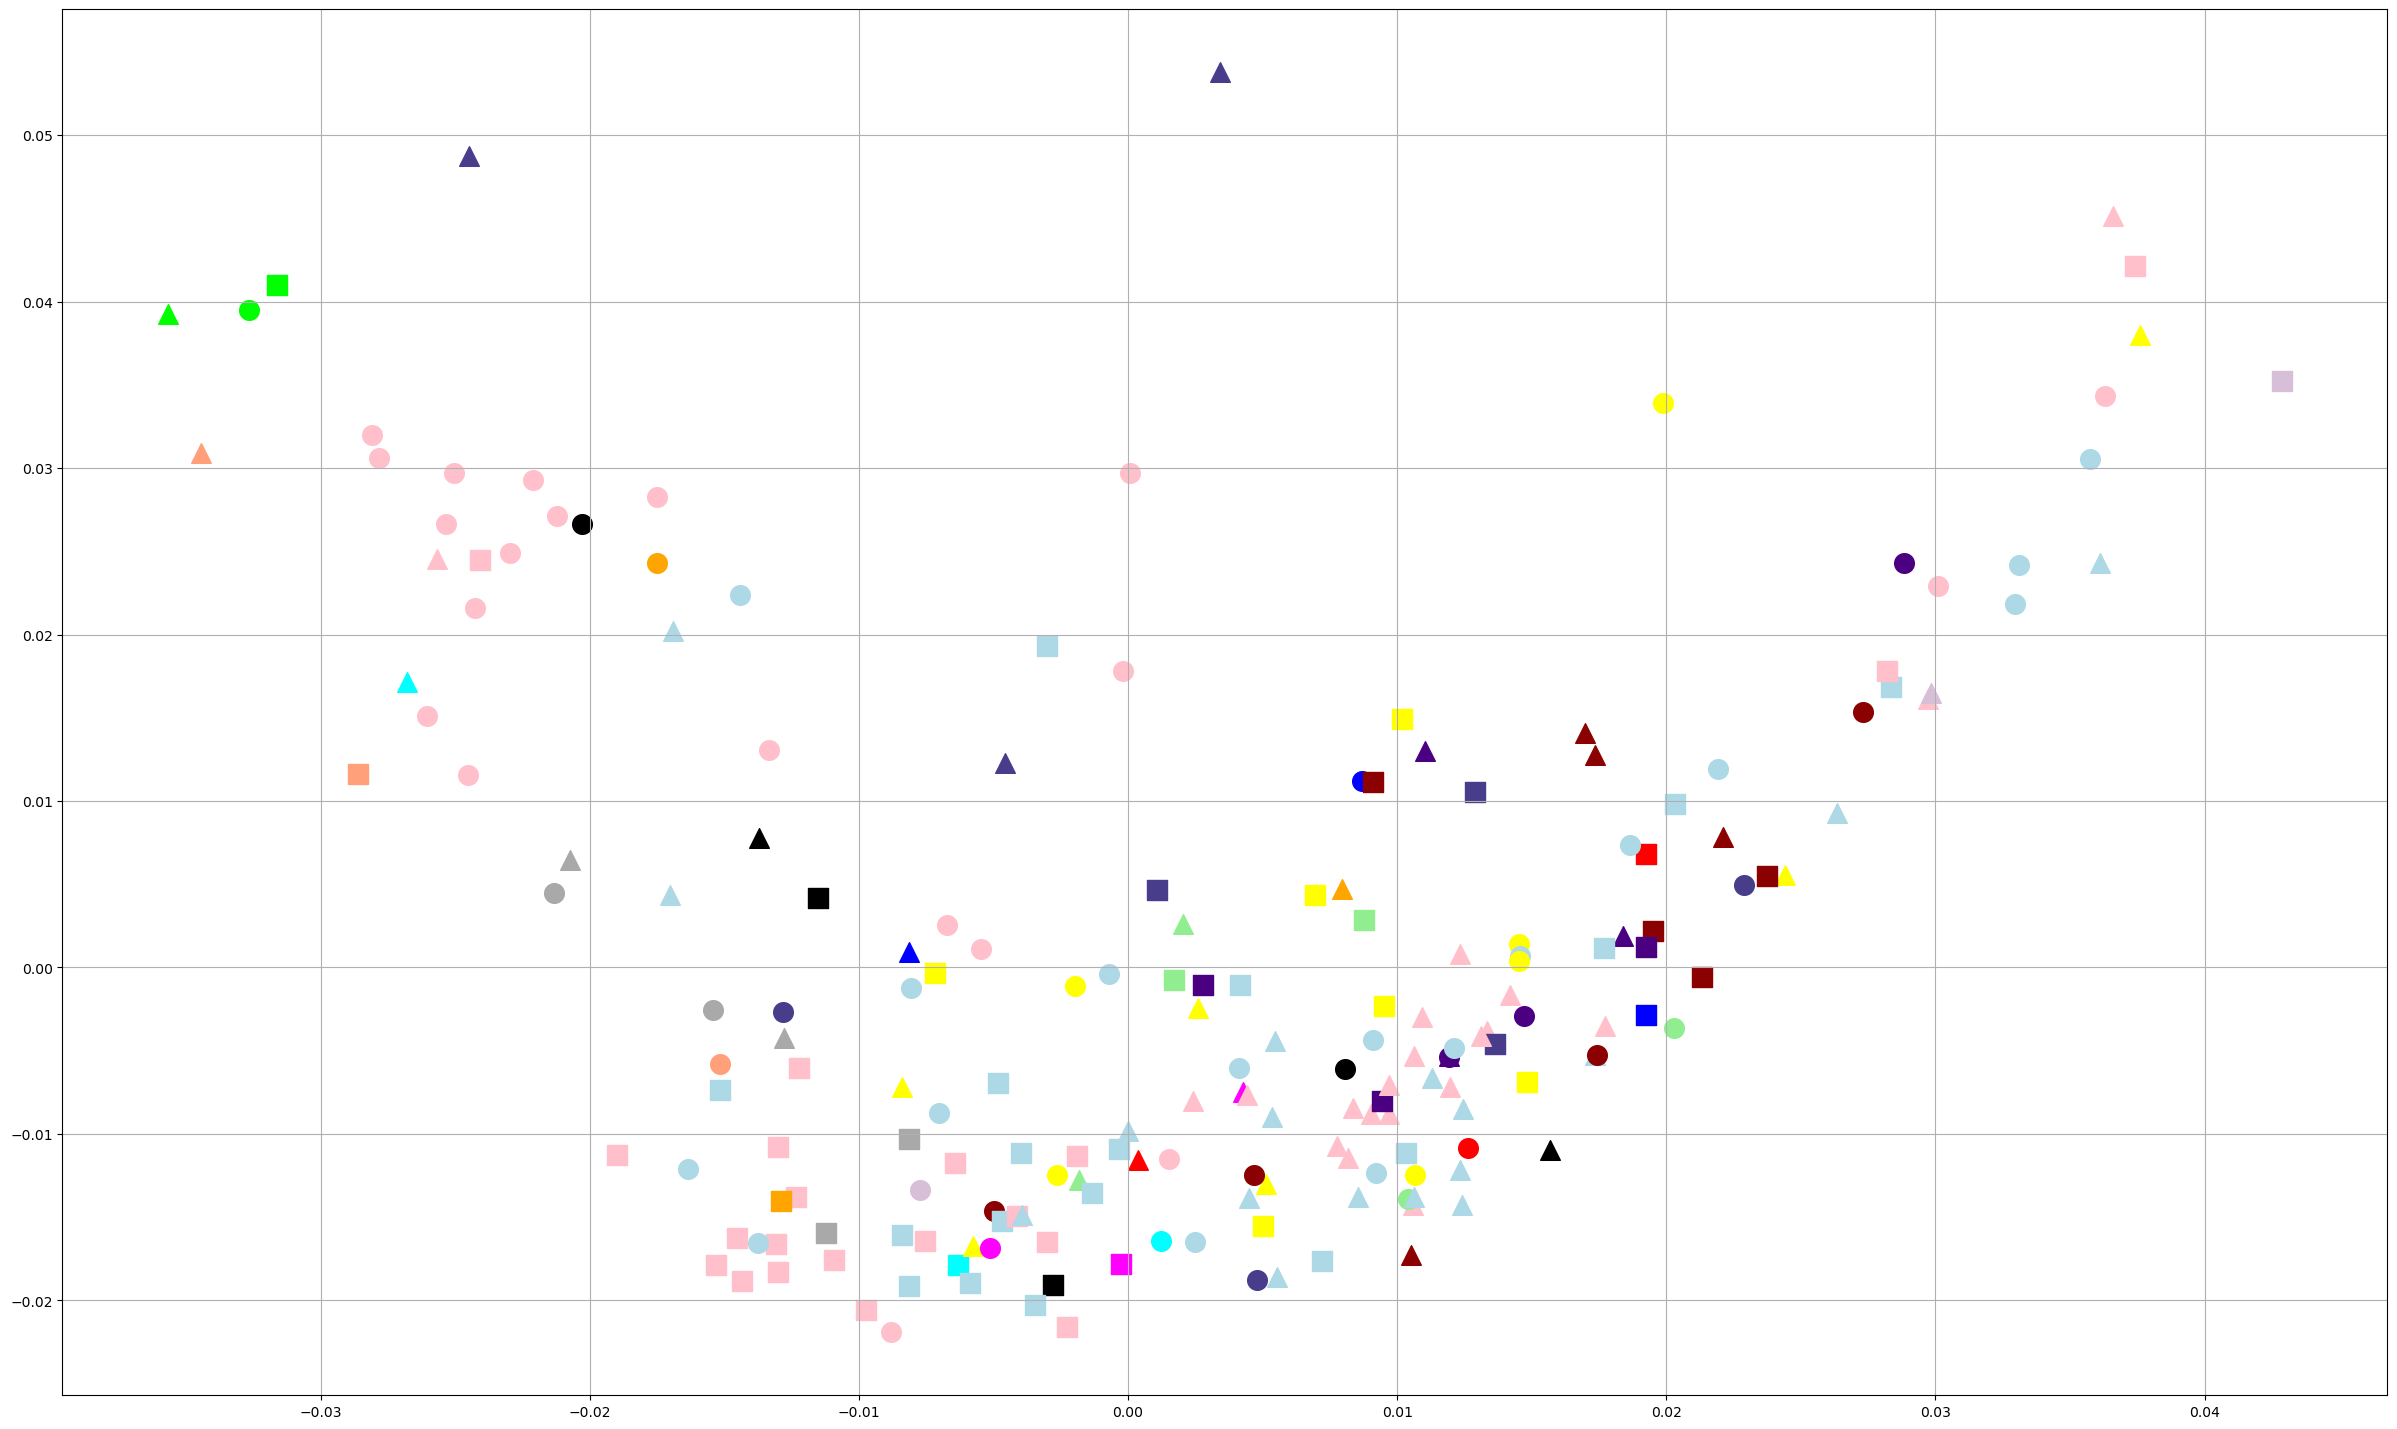

In [43]:
# SpectralEmbedding1
plt.figure(figsize=(30,18))
plt.grid()
# plt.xlim(digits_spec[:,0].min(),digits_spec[:,0].max()+1)
# plt.ylim(digits_spec[:,1].min(),digits_spec[:,1].max()+1)
#plt.xlim(-0.2,0.2)
for i in range(len(digits_spec)):
#     plt.text(digits_spec[i,0],digits_spec[i,1],str(new_name[i]),
#              color=colors[i],
#              fontdict={'weight':'bold','size':15})
    plt.scatter(digits_spec[i, 0], digits_spec[i, 1],s=200, color=color_map[names_all[i][10:]], marker=marker[i],label=names_all[i])
    
# new_texts = [plt.text(x_, y_, text, fontsize=12) for x_, y_, text in zip(digits_spec[:, 0], digits_spec[:, 1], names_all)]
# adjust_text(new_texts,arrowprops=dict(arrowstyle='->',color='red',lw=1))

# plt.legend(ncol=3)

#plt.savefig('C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\picture\\SE_VAE.png')  # 默认保存为PNG格式
plt.show()
#plt.close()  # 关闭图形，释放内存

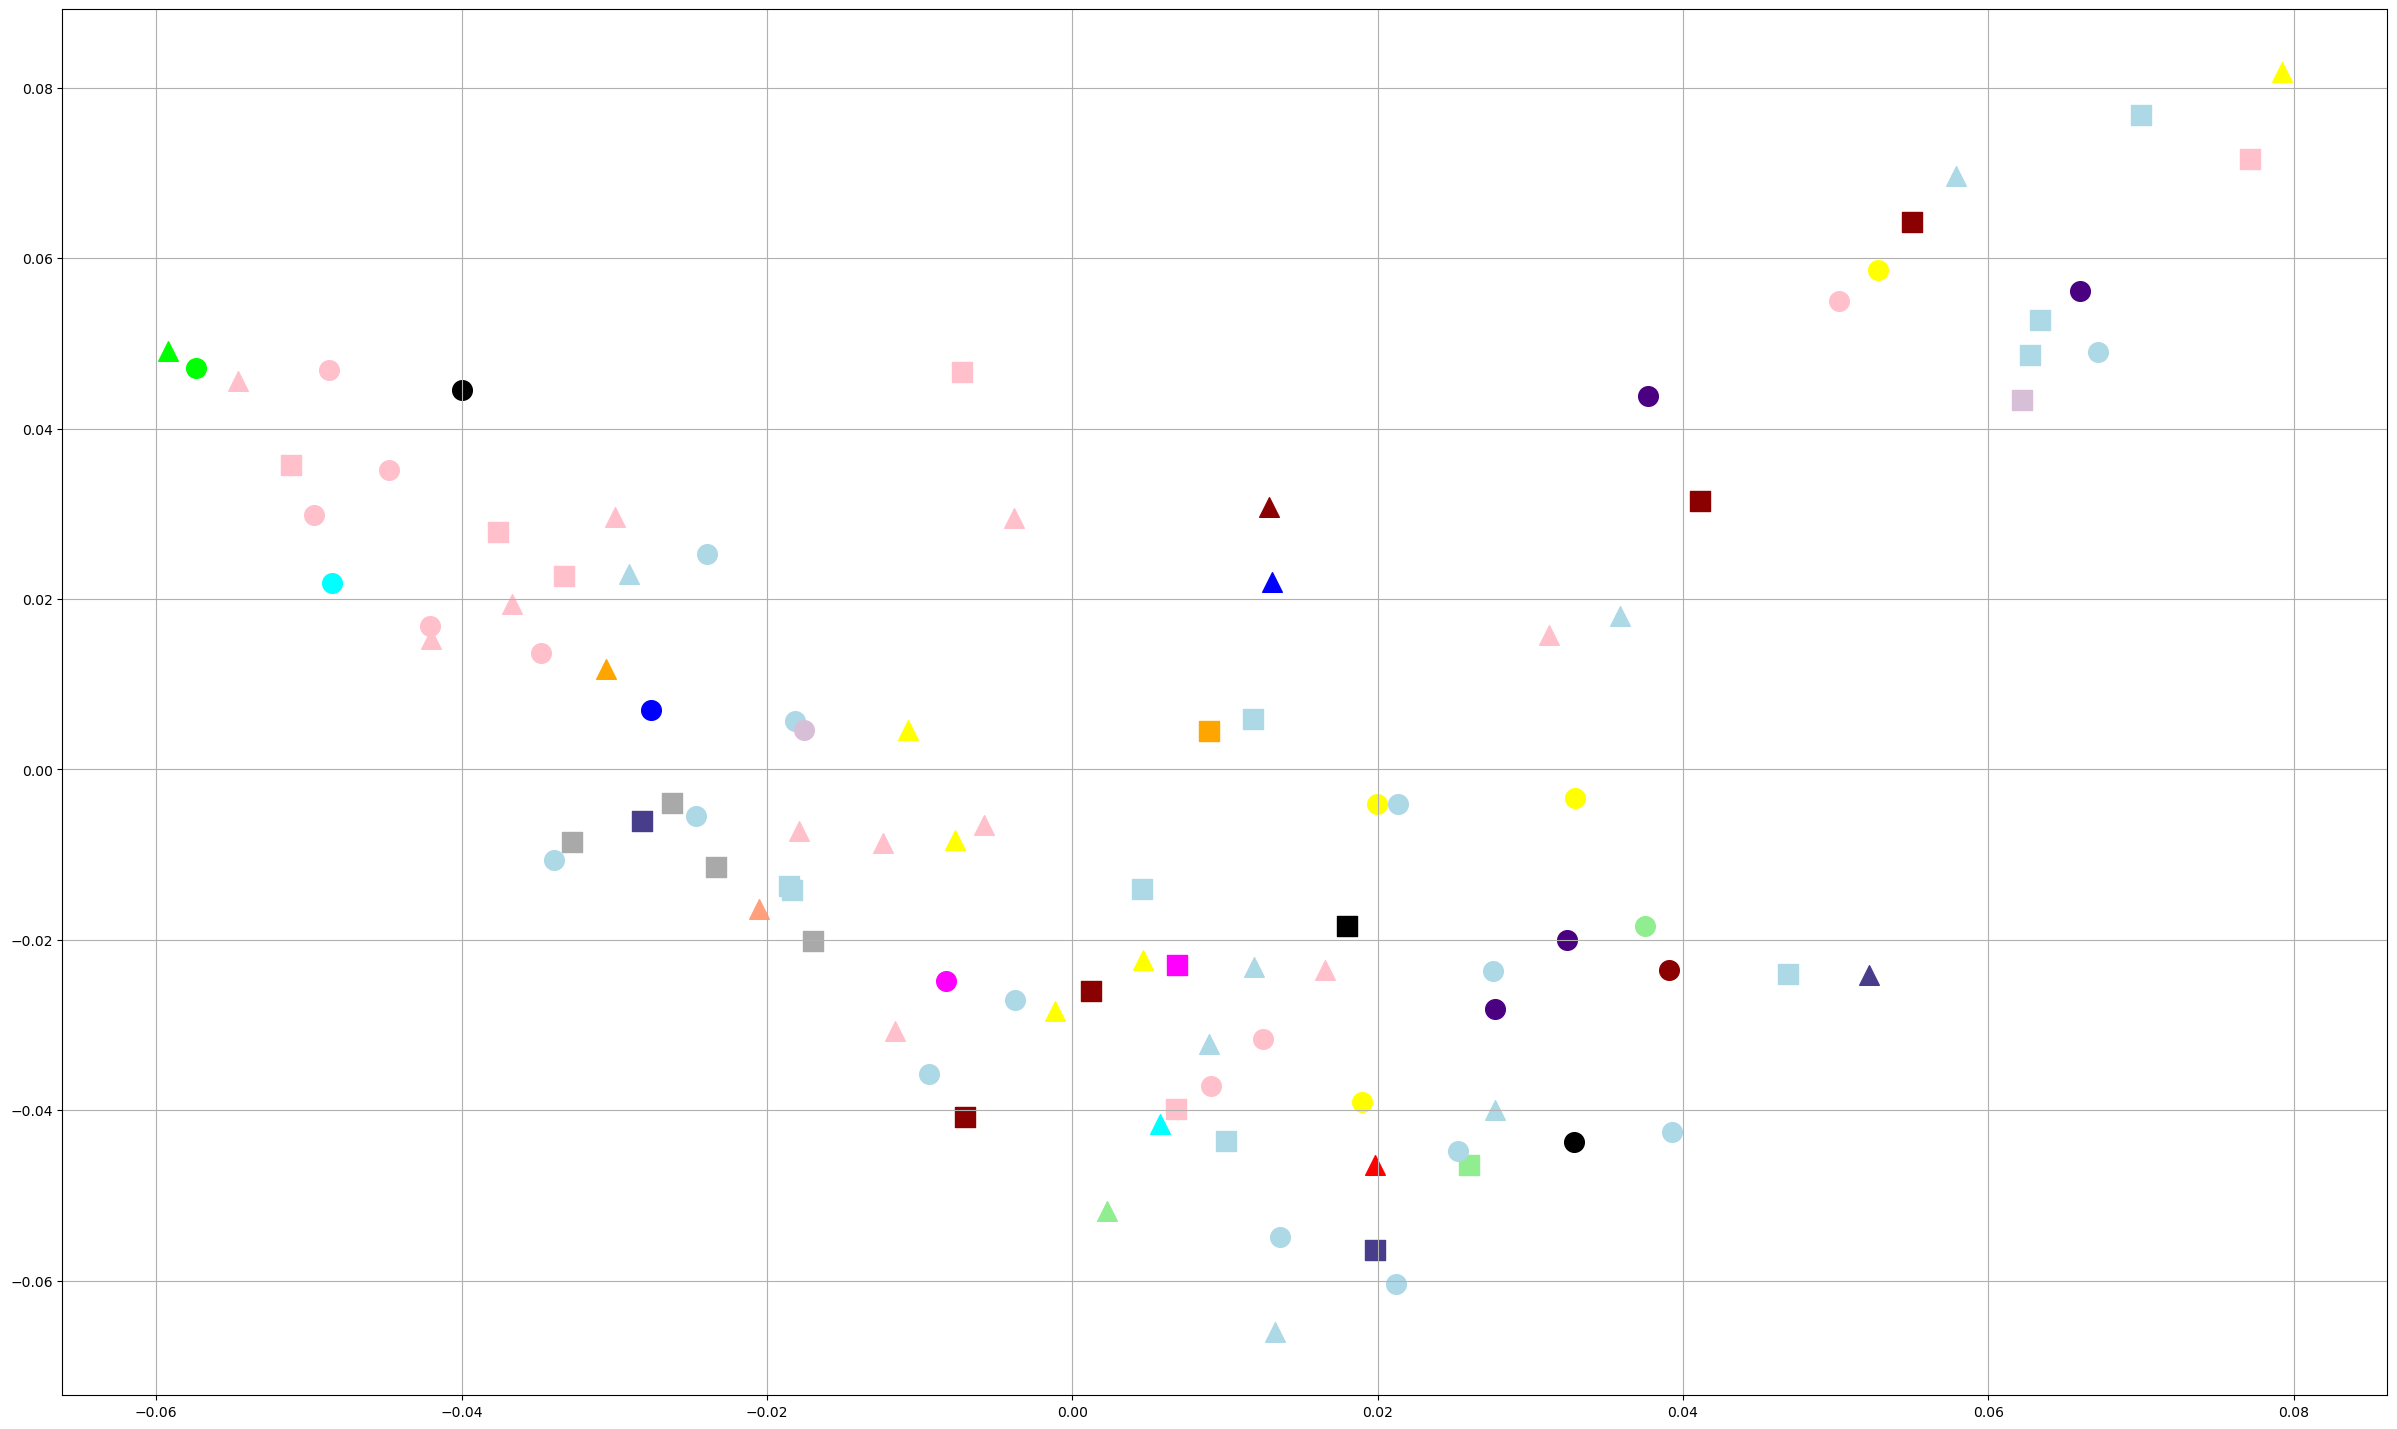

In [46]:
# SpectralEmbedding1
plt.figure(figsize=(30,18))
plt.grid()
# plt.xlim(digits_spec[:,0].min(),digits_spec[:,0].max()+1)
# plt.ylim(digits_spec[:,1].min(),digits_spec[:,1].max()+1)
#plt.xlim(-0.2,0.2)
for i in range(len(digits_spec2)):
#     plt.text(digits_spec[i,0],digits_spec[i,1],str(new_name[i]),
#              color=colors[i],
#              fontdict={'weight':'bold','size':15})
    plt.scatter(digits_spec2[i, 0], digits_spec2[i, 1],s=200, color=color_map[names_all2[i][10:]], marker=marker[i],label=names_all2[i])
    
# new_texts2 = [plt.text(x_, y_, text, fontsize=12) for x_, y_, text in zip(digits_spec2[:, 0], digits_spec2[:, 1], names_all2)]
# adjust_text(new_texts2,arrowprops=dict(arrowstyle='->',color='red',lw=1))

# plt.legend(ncol=3)

#plt.savefig('C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\picture\\SE_VAE(old data).png')  # 默认保存为PNG格式
plt.show()
#plt.close()  # 关闭图形，释放内存